# Strain and Voltage During Formation

Iaroslav Kovalchuk, Andrew Weng

2022/11/28

In [153]:
## Import all diferent libraries
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src import plotter as plotter

# Initialize Paths

In [156]:
plotter.initialize(plt)
target_dir = os.getcwd()

file_arbin_list = [
   f'{target_dir}/data/raw/from-voltaiq/UMBL2022FEB_CELL152098_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
   f'{target_dir}/data/raw/from-voltaiq/UMBL2022FEB_CELL152098_FORMFAST_2_P45C_5P0PSI_20220902_R1.csv',
   f'{target_dir}/data/raw/from-voltaiq/UMBL2022FEB_CELL152098_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
   f'{target_dir}/data/raw/from-voltaiq/UMBL2022FEB_CELL152098_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                  ]

daq_channel = 'Key_CH2'

# Load the Arbin Data

In [155]:
df_arbin_list = []

for file in file_arbin_list:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)


# Load the Keyence Data

In [ ]:

# Load the Keyence data
file_keyence = f'{target_dir}/data/raw/from-keyence/keyence_20220901_213928.csv'
df_keyence = pd.read_csv(file_keyence)
df_keyence['computer time'] = pd.to_datetime(df_keyence['computer time'], unit='s')
df_keyence['computer time'] = df_keyence['computer time'].apply(lambda x : x.tz_localize(None))

# Filter the Keyence data
df_keyence = df_keyence.loc[(df_keyence['computer time'] > df_arbin['Timestamp'].iloc[0]) & \
                            (df_keyence['computer time'] < df_arbin['Timestamp'].iloc[-1])]
y_strain = df_keyence[daq_channel] - df_keyence[daq_channel].iloc[0]
y_strain[y_strain > 500] = np.NaN

# Visualize the results

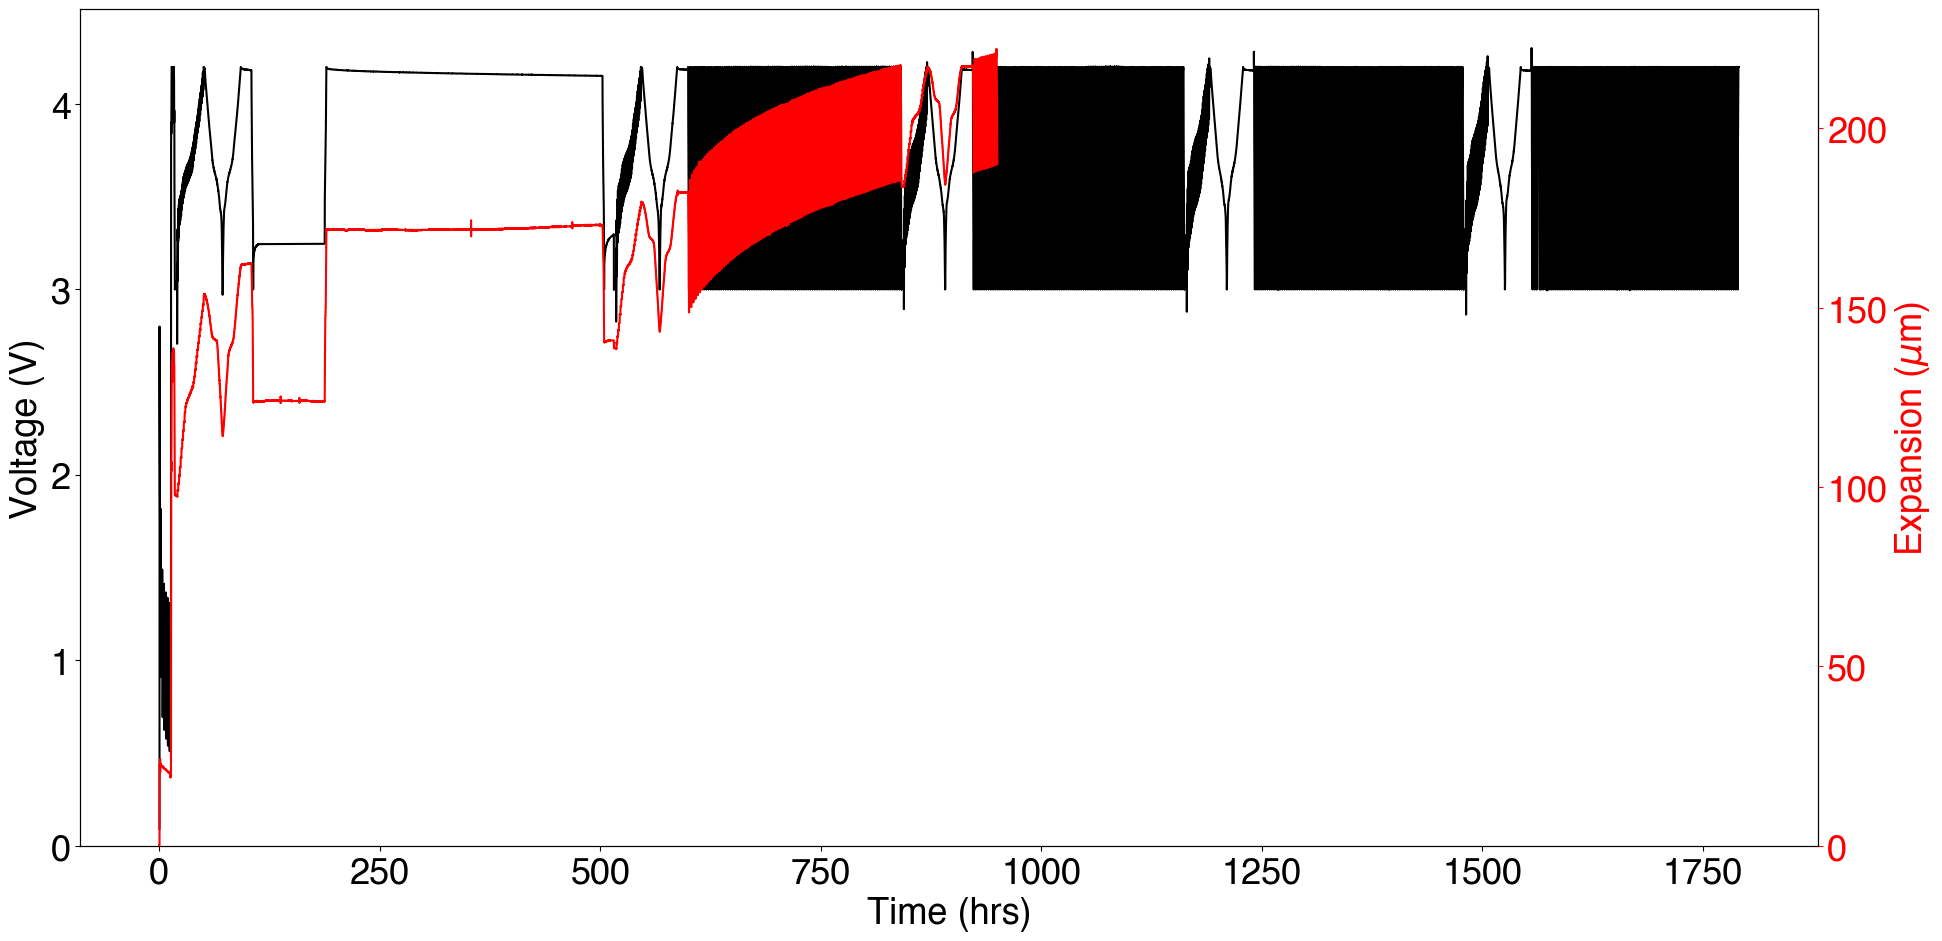

In [149]:
plt.figure(figsize=(20,10))

# The voltage plot
ax1 = plt.subplot()

tt = df_arbin['Timestamp'].astype(int)
tt = (tt - np.min(tt)) / 3600 / 1e9
y_voltage = df_arbin['Potential (V)']

ax1.plot(tt, y_voltage, color='k')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim(bottom=0)
ax1.grid(False)
# ax1.set_xlim((0, 2))

# The expansion plot
ax2 = ax1.twinx()

tt = df_keyence['computer time'].astype(int)
tt = (tt - np.min(tt)) / 3600 / 1e9

ax2.plot(tt, y_strain, color='r')
ax2.set_ylabel(r'Expansion ($\mu$m)')
ax2.tick_params(axis='y', colors='r')
ax2.yaxis.label.set_color('red')
ax2.set_ylim(bottom=0)
ax2.grid(False)
